# EECE-5554 Final Project: Trajectory Analysis

Using data collected from the RGB cameras mounted atop the NUance autonomous car at Northeastern University, we run ORB_SLAM3 to perform visual SLAM and end up with an estimate of our trajectory from the images alone. This trajectory is written to two files: one which contains a row for every frame, and one which contains only keyframes. A row contains the timestamp for that frame, as well as the translation and rotation (quaternion) of that frame relative to the first frame.

This script uses these trajectory files to create an overhead plot of the route taken by the car, so that it may be compared to the "ground truth" plot generated from GPS measurements.

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.spatial.transform import Rotation as R

The parameter `FILE_ID` sets which dataset will be used. Plots will be saved to the `plots` directory if the `SAVE_PLOTS` flag is set.

In [10]:
# FILE_ID = "f_dataset-MH01_mono"
# FILE_ID = "f_dataset_car_new_mono_2"
FILE_ID = "f_kevin_room_mono"
SAVE_PLOTS = True

We read in the data as a pandas dataframe.

In [11]:
# Read in data.
df = pd.read_csv("./data/"+FILE_ID+".txt", header=None, delim_whitespace=True)
df.columns = ['time','tx','ty','tz','qx','qy','qz','qw']
print("Setup dataframe with " + str(df.shape[0]) + " frames.")

Setup dataframe with 4119 frames.


This dataframe contains 7 columns aside from the stamped time which describe the transformation between frames. These columns are $t_x$, $t_y$, and $t_z$, the translation components, followed by $q_x$, $q_y$, $q_z$, $q_w$, the quaternion components. We can create a homogenous transformation matrix from each row to determine the car's pose at each frame, and we can string them all together to check that the final pose approximately matches the inital pose.

In [12]:
# For each frame, determine position.
T = np.eye(4)
pos_x = []; pos_y = []; pos_z = []
for i in range(len(df["time"])):
    t = [df["tx"][i], df["ty"][i], df["tz"][i]]
    q = [df["qw"][i], df["qx"][i], df["qy"][i], df["qz"][i]]
    # make it into an affine matrix.
    r = R.from_quat(q).as_matrix()
    # make affine matrix for transformation for this frame.
    T_frame = np.array([[r[0][0],r[0][1],r[0][2],t[0]],
                        [r[1][0],r[1][1],r[1][2],t[1]],
                        [r[2][0],r[2][1],r[2][2],t[2]],
                        [0,      0,      0,      1]])
    # add this frame's transformation to the cumulative T.
    T = T_frame * T
    # save (x,y) as current 2D position for this frame.
    pos_x.append(T_frame[0][3]); pos_y.append(T_frame[1][3]); pos_z.append(T_frame[2][3])
df["x"] = pos_x; df["y"] = pos_y; df["z"] = pos_z
# show overall transform (should be ~eye(4) for datasets that end at starting pos).
print(T)

[[-0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -4.17024525e-88 -0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


We now have an estimate of the car's position on each frame, so we can plot all of these to get an idea of whether this is even somewhat reasonable or not.

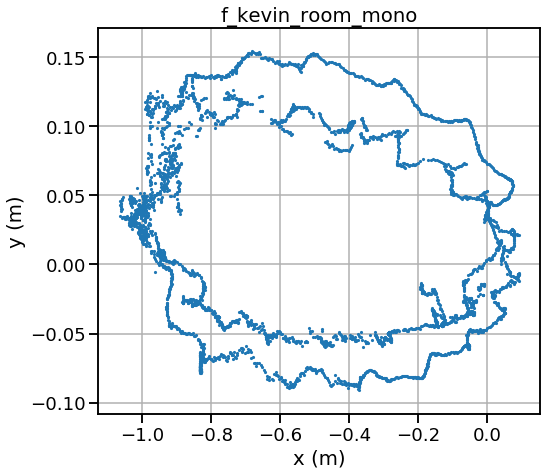

In [13]:
# do the plotting.
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(8,7))
plt.grid(True)
sns.scatterplot(x='x', y='y', data=df, palette='colorblind',s=10,linewidth=0,zorder=2)

# other plot formatting.
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title(FILE_ID)
plt.tight_layout()
# # save to a file in plots/ directory.
# if SAVE_PLOTS:
#     plt.savefig("./plots/"+FILE_ID+".png", format='png')
# show the plot.
plt.show()

In [14]:
def make_plot(x:str, y:str, SAVE_PLOTS=False):
    # make a plot for which the color changes as it goes on.
    plt.figure(figsize=(8,7))
    plt.grid(True)
    plt.scatter(df[x], df[y], s=5, c=df.time, cmap='Greens', edgecolors= "black", linewidth=0.2)

    # other plot formatting.
    plt.xlabel(x+" (m)")
    plt.ylabel(y+" (m)")
    plt.title(FILE_ID)
    plt.tight_layout()
    # save to a file in plots/ directory.
    if SAVE_PLOTS:
        plt.savefig("./plots/"+FILE_ID+".png", format='png')
    # show the plot.
    plt.show()

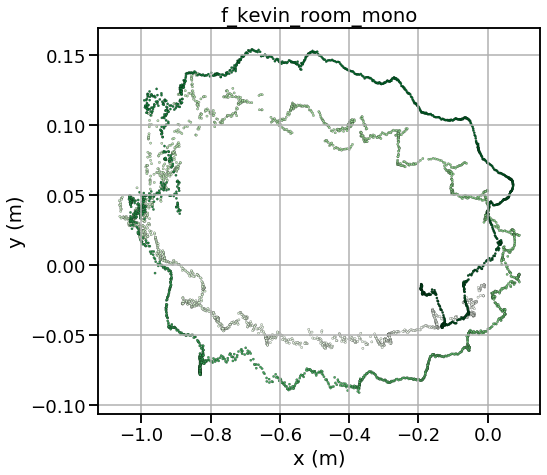

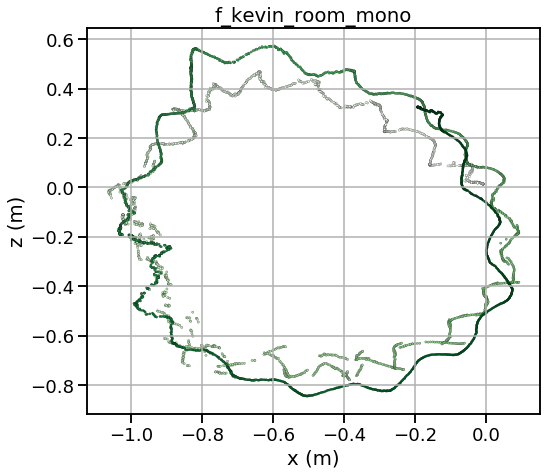

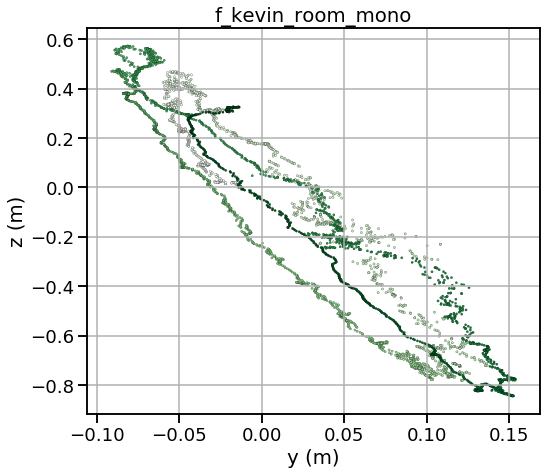

In [15]:
make_plot("x","y")
make_plot("x","z",SAVE_PLOTS=SAVE_PLOTS)
make_plot("y","z")

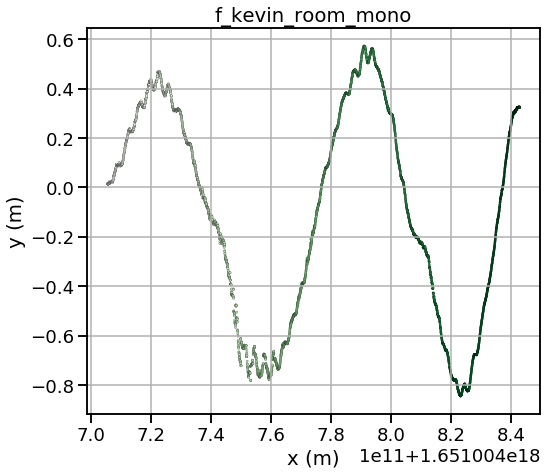

In [16]:
# plot components over time for comparison.
make_plot("time","x")
make_plot("time","y")
make_plot("time","z")